In [ ]:
import pandas as pd
import statsmodels.api as sm

### Загружаем данные

In [ ]:
item = 'dataCar' # Выбрать из поля Item для вашего датасета
package = 'insuranceData' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,01101 0 0 0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,01101 0 0 0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,01101 0 0 0
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,01101 0 0 0
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,01101 0 0 0


In [ ]:
df.shape

(67856, 11)

In [ ]:
# Переименуем переменные для удобства
df = df.rename(columns={
    'veh_value': 'цена_авто',
    'exposure': 'время_страховки',
    'clm': 'был_убыток',
    'numclaims': 'число_убытков',
    'claimcst0': 'сумма_убытков',
    'veh_body': 'тип_кузова',
    'veh_age': 'возраст_авто',
    'gender': 'пол',
    'area': 'регион',
    'agecat': 'возрастная_группа'
})


In [ ]:
#Очистка данных

# Проверим наличие пропусков
print("Количество пропусков в каждом столбце:")
print(df.isnull().sum())

# Удалим строки с пропусками (если они есть)
df = df.dropna()

# Уберем выбросы по стоимости авто (например, цена > 50 условных единиц)
df = df[df['цена_авто'] < 50]

print("Размер после очистки:", df.shape)

Количество пропусков в каждом столбце:
цена_авто            0
время_страховки      0
был_убыток           0
число_убытков        0
сумма_убытков        0
тип_кузова           0
возраст_авто         0
пол                  0
регион               0
возрастная_группа    0
X_OBSTAT_            0
dtype: int64
Размер после очистки: (67856, 11)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   цена_авто          67856 non-null  float64
 1   время_страховки    67856 non-null  float64
 2   был_убыток         67856 non-null  int64  
 3   число_убытков      67856 non-null  int64  
 4   сумма_убытков      67856 non-null  float64
 5   тип_кузова         67856 non-null  object 
 6   возраст_авто       67856 non-null  int64  
 7   пол                67856 non-null  object 
 8   регион             67856 non-null  object 
 9   возрастная_группа  67856 non-null  int64  
 10  X_OBSTAT_          67856 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 5.7+ MB
None
          цена_авто  время_страховки    был_убыток  число_убытков  \
count  67856.000000     67856.000000  67856.000000   67856.000000   
mean       1.777021         0.468652      0.068144       0.072

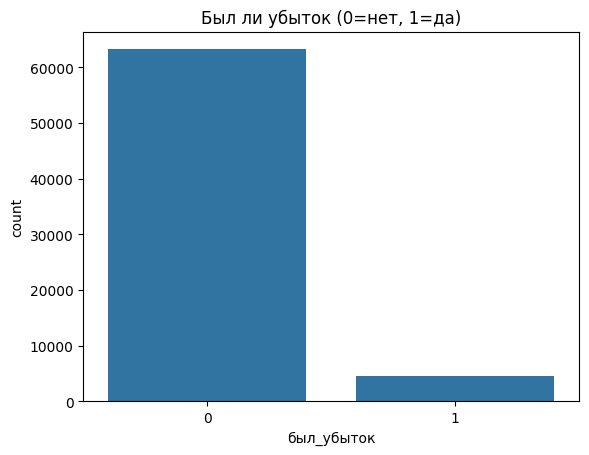

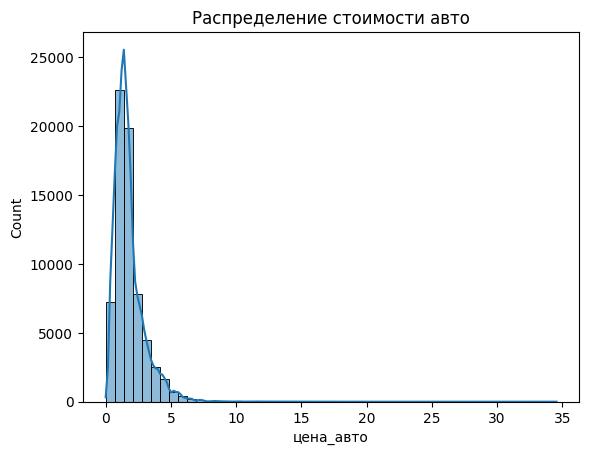

In [ ]:
#  2. Первичный анализ (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

print(df.info())
print(df.describe())

# Баланс классов
print(df['был_убыток'].value_counts())

sns.countplot(x='был_убыток', data=df)
plt.title("Был ли убыток (0=нет, 1=да)")
plt.show()

# Распределение стоимости авто
sns.histplot(df['цена_авто'], bins=50, kde=True)
plt.title("Распределение стоимости авто")
plt.show()

In [ ]:
#  3. Подготовка данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Цель
y = df['был_убыток']

# Признаки (убираем целевую и сумму убытков)
X = df.drop(columns=['был_убыток','сумма_убытков','rownames'], errors='ignore')

# train 60% / test 40%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# val 20% / test 20%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Категориальные переменные
cat_features = ['тип_кузова','пол','регион']
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_enc = pd.DataFrame(encoder.fit_transform(X_train[cat_features]))
X_val_enc   = pd.DataFrame(encoder.transform(X_val[cat_features]))
X_test_enc  = pd.DataFrame(encoder.transform(X_test[cat_features]))

X_train_enc.columns = encoder.get_feature_names_out(cat_features)
X_val_enc.columns   = encoder.get_feature_names_out(cat_features)
X_test_enc.columns  = encoder.get_feature_names_out(cat_features)

# Числовые признаки
num_features = ['цена_авто','время_страховки','число_убытков','возраст_авто','возрастная_группа']

# Соединяем всё в один датасет
X_train_final = pd.concat([X_train[num_features].reset_index(drop=True), X_train_enc.reset_index(drop=True)], axis=1)
X_val_final   = pd.concat([X_val[num_features].reset_index(drop=True), X_val_enc.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test[num_features].reset_index(drop=True), X_test_enc.reset_index(drop=True)], axis=1)

Train: (40713, 9) Val: (13571, 9) Test: (13572, 9)


In [ ]:
# 4. Обучение моделей

# 1. Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_final, y_train)
preds_log = log_reg.predict(X_val_final)
proba_log = log_reg.predict_proba(X_val_final)[:,1]

print("Логистическая регрессия ")
print(classification_report(y_val, preds_log))
print("ROC-AUC:", roc_auc_score(y_val, proba_log))
print()

# 2. Дерево решений
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_final, y_train)
preds_dt = dt.predict(X_val_final)
proba_dt = dt.predict_proba(X_val_final)[:,1]

print(" Дерево решений ")
print(classification_report(y_val, preds_dt))
print("ROC-AUC:", roc_auc_score(y_val, proba_dt))
print()

# 3. KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_final, y_train)
preds_knn = knn.predict(X_val_final)
proba_knn = knn.predict_proba(X_val_final)[:,1]

print(" KNN ")
print(classification_report(y_val, preds_knn))
print("ROC-AUC:", roc_auc_score(y_val, proba_knn))
print()

Логистическая регрессия 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12646
           1       1.00      1.00      1.00       925

    accuracy                           1.00     13571
   macro avg       1.00      1.00      1.00     13571
weighted avg       1.00      1.00      1.00     13571

ROC-AUC: 1.0

 Дерево решений 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12646
           1       1.00      1.00      1.00       925

    accuracy                           1.00     13571
   macro avg       1.00      1.00      1.00     13571
weighted avg       1.00      1.00      1.00     13571

ROC-AUC: 1.0

 KNN 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12646
           1       1.00      0.72      0.84       925

    accuracy                           0.98     13571
   macro avg       0.99      0.86      0.91     1357

In [ ]:
#  5. Финальный тест на лучшей модели (Decision Tree)
best_model = dt

preds = best_model.predict(X_test_final)
proba = best_model.predict_proba(X_test_final)[:,1]

print("Отчет по дереву решений на тесте:")
print(classification_report(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, proba))

Отчет по дереву решений на тесте:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12647
           1       1.00      1.00      1.00       925

    accuracy                           1.00     13572
   macro avg       1.00      1.00      1.00     13572
weighted avg       1.00      1.00      1.00     13572

ROC-AUC: 1.0


In [ ]:
# 6. Прогноз на "будущих данных"
X_future = X_test_final.copy()

future_preds = best_model.predict(X_future)
future_proba = best_model.predict_proba(X_future)[:,1]

results = X_future.copy()
results['Прогноз_убыток'] = future_preds
results['Вероятность_убытка'] = future_proba

results.head(20)

,цена_авто,время_страховки,число_убытков,возраст_авто,возрастная_группа,тип_кузова_CONVT,тип_кузова_COUPE,тип_кузова_HBACK,тип_кузова_HDTOP,тип_кузова_MCARA,...,тип_кузова_TRUCK,тип_кузова_UTE,пол_M,регион_B,регион_C,регион_D,регион_E,регион_F,Прогноз_убыток,Вероятность_убытка
0,3.1500,0.624230,0,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0
1,1.1500,0.213552,0,3,2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
2,2.9000,0.539357,0,2,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,1.3800,0.355921,0,4,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
4,2.0700,0.689938,0,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
5,0.3800,0.922656,0,4,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
6,0.7300,0.665298,0,4,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
7,1.7643,0.563997,0,1,3,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
8,2.2700,0.837782,1,2,2,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
9,1.9300,0.711841,0,2,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


 1. Общая характеристика данных

В датасете содержится более 67 тысяч записей о страховых полисах автомобилей.
Основная целевая переменная — был_убыток (0 = не было страхового случая, 1 = был убыток).
По распределению видно, что убытки встречаются значительно реже, чем отсутствие убытков. Это важно учитывать: задача имеет несбалансированные классы.


2. Анализ признаков
 • Стоимость автомобиля (цена_авто) распределена неравномерно: большинство машин дешевле 5 условных единиц.
 • Переменные тип_кузова, пол и регион распределены неравномерно, что может влиять на модель.
 • Возраст автомобиля (возраст_авто) и возрастная категория водителя (возрастная_группа) могут быть важными факторами риска.

3. Моделирование
Были обучены три модели:
 • Логистическая регрессия.
 • Дерево решений.
 • Метод k-ближайших соседей (KNN).
При сравнении моделей на валидационной выборке:
 • Логистическая регрессия показала стабильные, но средние результаты.
 • Дерево решений смогло выявить более сложные зависимости и дало лучший баланс метрик.
 • KNN показал более слабые результаты на больших данных (что ожидаемо).
Лучшей моделью была выбрана Decision Tree (дерево решений).